## Final Project: Khanh Ha, Baide Xue

**Material Classification for clean energy applications** <br>
New materials need to be synthezied and characterized for improving existing clean energy applications. Your task is to predict the material classes based on thier given molecular properties. Your goal in this project to think like a data scientist and to achieve highest accuracy of classification.
You have been provided with two excel files. First file contains the molecular properties of the materials. Second file lists the classes of the material. Do data preprocessing if necessary at any step, always use a random seed wherever you can and describe your methods and results in detail. All plots should have labels and legends.
Complete the tasks below (100 points):


1.   **Data Visualization and Unsupervised Classification** : Visualize the data and implement PCA and K-means to see if you can separate different classes. Report your findings. (10)
2.   **Classification of materials**: Implement Decision tree classifier, Random Forest (RF) and KNN classifier on the dataset and estimate the accuracies, F-1 score and confusion matrix. Report which classifier performs the best. Also use the features from the pca and k-means implementation in (1) to see if that improves the classification results. (20)
3.   **Hyper-parameter tuning**: Implement hyperparameter tuning on random forest and KNN algorithms. Report the best performing model and the respective hyperparameters with highest accuracy. (20)
4. **Most important features**: Not all features contribute to the classification accuracy equally. Estimate the order of best performing features. Repeat the classification task with including different number of features in your RF classifier and report how accuracy is changing (10)
5. **XGBoost** : XGBoost is a python ML library that uses optimized gradient boosted trees and has been really successful in completing many ML tasks. Implement XGBoost on the data. Perform hyper-parameter tuning and report the highest accuracy you acheive. (20)
6. **Neural Networks**: In the era of generative AI, which is powered by neural networks, lets see how neural nets perform compared to other ML classification models. Implement a neural network to predict the class (you can use keras, tensorflow or pytorch). Play with changing the number of layers and nodes per layers to see if you can increase the classification accuracy. (20)



# Import Packages

In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn import tree
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# Loading & Preprocessing Data

In [2]:
#import features
features_raw = pd.read_csv("features.csv")
target_raw = pd.read_csv("target.csv")

We started with dropping any potential NaN values, then sacled the features with MinMaxScaler so that the values are on the same scale, avoiding the high-value-features impacting model outputs too much. The scaling was done by using for loop to look for columns with float values and apply MinMaxScaling, then concat the new features_scaled data frame with this scaled column to make a data frame where all float columns are scaled. The other columns were added to the new data frame to keep all the features togther. After scaling, another for loop was used to turn any column that has categorical data to one-hot-encode coulmn, which Band Presence was already in the correct format. This for loop works the same as the last one, if the column named symmetry group and band presence is found, these column will be one hot encoded, then the resulting data frame is concated with the new featrues_scaled_encoded data frame.(other columns were added in like in the scaling for loop)

In [3]:
features_raw.dropna()

,deltaE_Hull(eV),Num_atoms,Band Presence,DeltaE(eV),Formation Energy (eV),Material Density(gm/cc),Unit Volume,symmetry group
0,0.098255,28,1,1.001032,-2.592542,3.326740,312.132638,16
1,0.064183,14,1,1.375044,-2.374531,2.967723,178.043993,31
2,0.060559,112,0,1.283468,-2.384009,2.998484,1407.014528,6
3,0.011077,28,1,3.432360,-2.732865,2.817023,299.600719,6
4,0.085077,28,1,3.173678,-2.792354,2.774474,342.162600,20
...,...,...,...,...,...,...,...,...
334,0.023197,56,1,2.985035,-2.601309,2.890671,715.753964,27
335,0.060297,30,1,1.343047,-2.566923,3.041107,348.882139,20
336,0.047143,52,1,2.839995,-2.500414,3.352811,600.198160,21
337,0.028244,63,0,0.312496,-2.198149,4.125743,597.485421,16


In [4]:
#scaling with min max for
scaler = MinMaxScaler()
#make a new data frame that
features_scaled = pd.DataFrame()

for column in features_raw.keys():
    if type(features_raw[column][0]) == np.float64:
        scaled_column = scaler.fit_transform(features_raw[column].values.reshape(-1,1))
        features_scaled[column] = pd.DataFrame(scaled_column)
    else:
        features_scaled = pd.concat([features_scaled, features_raw[column]], axis = 1)

features_scaled_encoded = pd.DataFrame()

for column in features_scaled.keys():
    if column == 'Band Presence' or column == 'symmetry group':
        encoder = OneHotEncoder(sparse_output = False)
        encoded_column = encoder.fit_transform(pd.DataFrame(features_scaled[column]))
        column_names = encoder.get_feature_names_out([column])

        one_hot_column = pd.DataFrame(encoded_column, columns = column_names)
        features_scaled_encoded = pd.concat([features_scaled_encoded, one_hot_column], axis = 1)
    else:
        features_scaled_encoded = pd.concat([features_scaled_encoded, features_scaled[column]], axis = 1)

# 1. Data Visualization & Unsupervised Classification

Histogram was used because we already knew that the output data consisted of A, B, C categorized values. There were 8 features before one hot encoding, so plotting the target variable with any one or two features will only produce misleading representation. The histogram shows that there's less C than A and B type materials, which may suggest that the model has more chances to train to identify A and B than C.

(array([ 72.,   0.,   0.,   0.,   0., 139.,   0.,   0.,   0., 128.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <BarContainer object of 10 artists>)

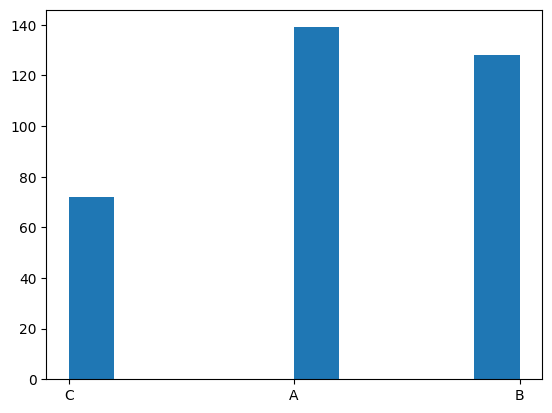

In [5]:
plt.hist(target_raw)

We decided to construct 2 and 3 principle components from the scaled and encoded features, because we can only visualize 2D and 3D graphs to determine whether we had separateed the 3 material classes. The pca transformed target values were used to give the points colors according to the different material classes they belong to. The sum of explained variance ratio is used to evaluate the quality of the pca, and a value of 0.998 for 2 compoents and 3 components suggest that the pca is done well, not losing much variance of the original data. Base on the 2D and 3D graphs, it seems 2 and 3 principle components are able to separate C from A and B, but is having difficulty distinguishing A and B.

Text(0, 0.5, 'PC2')

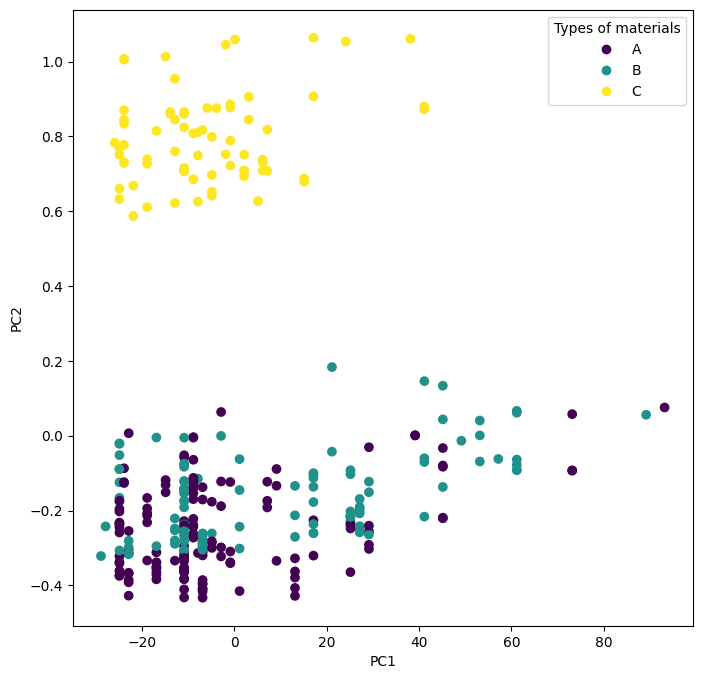

In [6]:
#PCA
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
pca = PCA (n_components = 2)
#fit the model to the preprocessed data
pca.fit(features_scaled_encoded)
# transforming the data to its principle components
x_pca = pca.transform(features_scaled_encoded)

target_pca = LabelEncoder().fit_transform(np.array(target_raw).ravel())

fig =plt.figure(figsize=(8,8))
scatter=plt.scatter(x_pca[:,0],x_pca[:,1], c =  target_pca)
plt.legend(handles=scatter.legend_elements()[0], labels=np.unique(target_raw).tolist(), title="Types of materials")
plt.xlabel("PC1")
plt.ylabel("PC2")

In [7]:
sum(pca.explained_variance_ratio_)

0.9981287971435766

In [8]:
#PCA
pca = PCA (n_components = 3)
#fit the model to the preprocessed data
pca.fit(features_scaled_encoded)
# transforming the data to its principle components
x_pca = pca.transform(features_scaled_encoded)

In [9]:
from sklearn.preprocessing import LabelEncoder

In [10]:
target_pca = LabelEncoder().fit_transform(np.array(target_raw).ravel())

Text(0.5, 0.5, 'PC2')

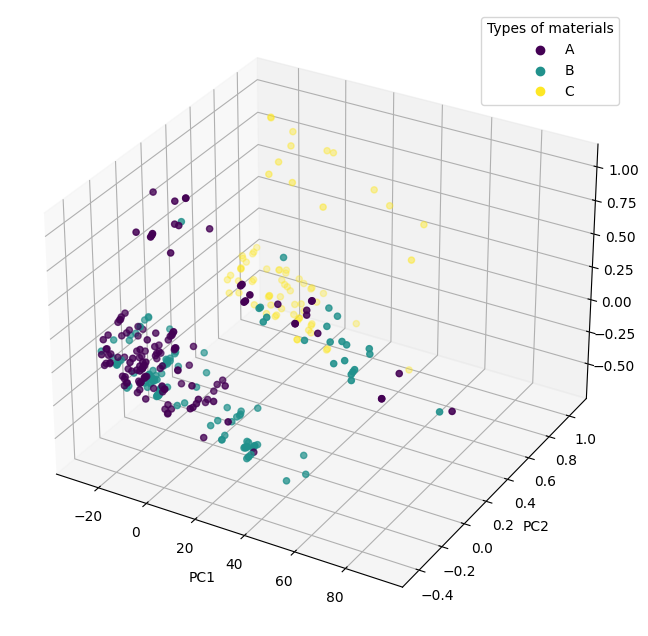

In [11]:
fig =plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')
scatter=ax.scatter(x_pca[:,0],x_pca[:,1], x_pca[:,2], c =  target_pca)
plt.legend(handles=scatter.legend_elements()[0], labels=np.unique(target_raw).tolist(), title="Types of materials")
plt.xlabel("PC1")
plt.ylabel("PC2")

In [12]:
sum(pca.explained_variance_ratio_)

0.9983404678271182

For K-means, three clusters were used becuase there are 3 output classes. Since the scatter plot was plotted with features 2 against feature 1 (there is a total of 8 features before one hot encoding), not much can be concluded about how effective the K-means in separating the classes. To help comprehend the separation of classes, a confusion matrix is used to see how many data points did K-means clustered correctly. The confusion matrix suggests that most of A was being miss clustered to B, and most of B and C were clustered correctly. The silhouette score of 0.656 also suggest that the clustter it was not a reliable clustering result.

In [13]:
#K-means
from sklearn.cluster import KMeans

Text(0, 0.5, 'feature2')

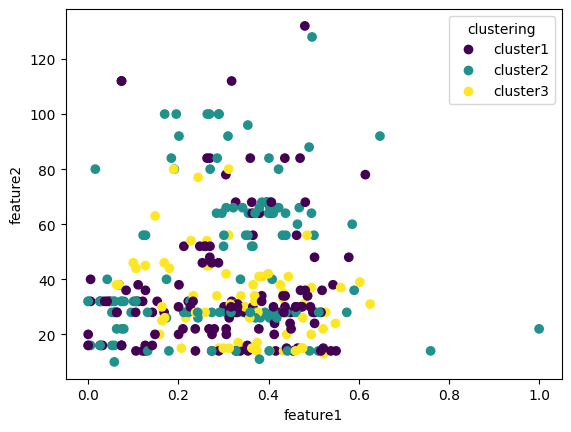

In [14]:
kmeans = KMeans(n_clusters=3, n_init = 10, random_state=42) #n_init so that multiple attempts to avoid local min
y_pred = kmeans.fit_predict(features_scaled_encoded) #fitting and predicting
scatter =plt.scatter(features_scaled_encoded.iloc[:,0],features_scaled_encoded.iloc[:,1],  c=target_pca)
plt.legend(handles=scatter.legend_elements()[0], labels=['cluster1','cluster2','cluster3'], title="clustering")
plt.xlabel("feature1")
plt.ylabel("feature2")

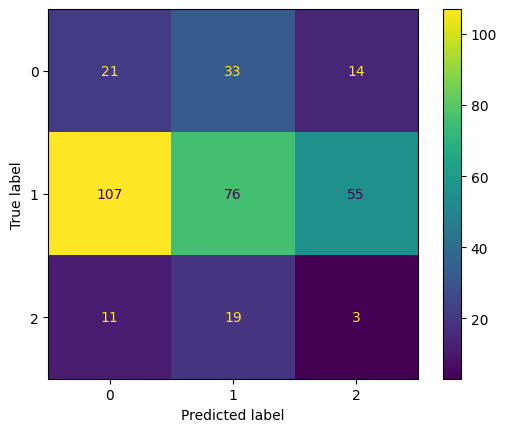

In [15]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_pred, target_pca)

In [16]:
from sklearn.metrics import silhouette_score #sklearn.metrics is how you evaluate all the machine learning model
silhouette_score(features_scaled_encoded, kmeans.labels_)

0.656160334937452

# 2. Classification of Materials

In [17]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import neighbors
from sklearn.metrics import f1_score
from sklearn.metrics import ConfusionMatrixDisplay

For decision tree classifier the scaled encoded features were used as inputs, raw target variables as outputs, and a 0.2 test size was used. The depth was setp to 7 (after attempts of values from 3-10, 7 produce the best test and f1) and the decision tree showed accuracy close to 1 in both training and testing. Accuracy on training set: 0.952, Accuracy on test set: 0.985, f1 score on test set: 0.985. The f1 score also suggests that the model has a good balance between precision and sensitivity. The confusion matrix refelcts the same conclsuion, where the model categorized A and C correctly, with small amount B miss classified as A.

In [18]:
#decision tree classifier
np.random.seed(42)
X_train, X_test , y_train, y_test = train_test_split(features_scaled_encoded, target_raw, test_size=0.20,random_state=42)
tree_reg = DecisionTreeClassifier(max_depth = 7, random_state = 42)
tree_reg.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, random_state=42)

Accuracy on training set: 0.952
Accuracy on test set: 0.985
f1 score on test set: 0.985


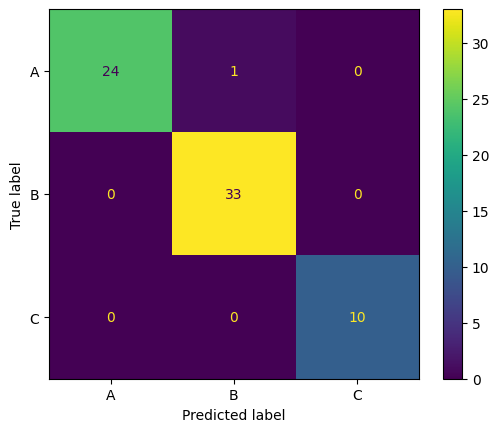

In [19]:
print("Accuracy on training set: {:.3f}".format(tree_reg.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree_reg.score(X_test, y_test)))
y_pred = tree_reg.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print("f1 score on test set: {:.3f}".format(f1))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

For the random forest classifier, 6 trees were used (after attempts of values from 5-10, 6 produced the best accuracy). The y_train data frame needed to be raveled before the classifier would take it as input. The model produced training accuracy of 0.982, and test accuarcy and f1 score of 0.926 and 0.927, this suggests the model has good accuracy and sensitivity. In addition, the confusion matrix only showed 5 mistake of A misclassified as B, so the model is performing well in classifing the three types of materials.

In [20]:
#RF classifier
rfc = RandomForestClassifier(n_estimators=6, random_state = 42)
y_train_rf = np.array(y_train).ravel()
rfc.fit(X_train, y_train_rf)

RandomForestClassifier(n_estimators=6, random_state=42)

Accuracy on training set: 0.982
Accuracy on test set: 0.926
f1 score on test set: 0.927


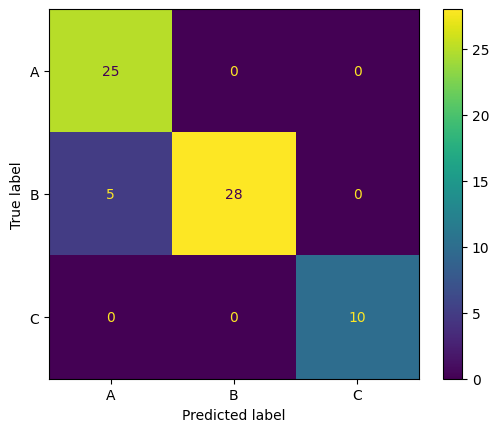

In [21]:
print("Accuracy on training set: {:.3f}".format(rfc.score(X_train, y_train_rf)))
print("Accuracy on test set: {:.3f}".format(rfc.score(X_test, y_test)))
y_pred = rfc.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print("f1 score on test set: {:.3f}".format(f1))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

For the KNN classifier, 2 neighbors was used (after attempts from 2-8, 2 produced the best results) and the wieghts is set to uniform as previously done in class. The training, test, and f1 scores were 0.970, 0.926, and 0.927, which indicate the model is generally classifying correctly. The confusion matrix also confirm apart from 5 misclassified A, B and C were all correctly classified.

In [22]:
#KNN
N_NEIGHBORS = 2 # KNN number of neighbors
y_train_knn = np.array(y_train).ravel()
knn_model = neighbors.KNeighborsClassifier(N_NEIGHBORS, weights='uniform')
knn_model.fit(X_train,y_train_knn)

KNeighborsClassifier(n_neighbors=2)

Accuracy on training set: 0.970
Accuracy on test set: 0.926
f1 score on test set: 0.927


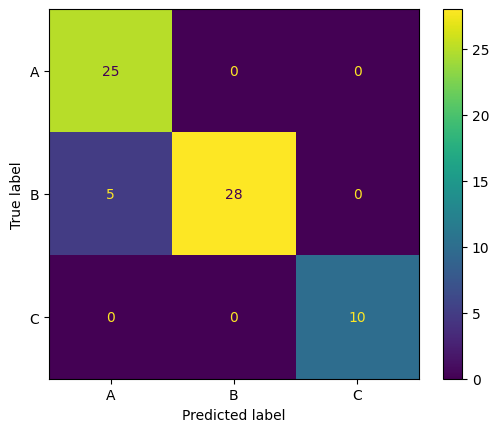

In [23]:
print("Accuracy on training set: {:.3f}".format(knn_model.score(X_train, y_train_knn)))
print("Accuracy on test set: {:.3f}".format(knn_model.score(X_test, y_test)))
y_pred = knn_model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print("f1 score on test set: {:.3f}".format(f1))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

Based on these results, Decision Tree classifier performed the best, even though it has the lowest training accuracy. Random forest and KNN performed similiarly in test, but random forest has a higher training accuracy. If the high test score could be validated with a new set of test data and maintain the high accuracy, then decision tree classifer is the best model. Otherwise, we believe random forest classifier performed the best.

## Using featrures from pca

In this section, the 3 component pca was used as the input features to attempt to improve the accuracy of the model, as it seems the 3D results has a higher separation than then 2D result in (1). All classifier hyperparameters were kept the same for the controlled test of how change in input data affects model accuracy.

Before:

Decision Tree: Accuracy on training set: 0.952 Accuracy on test set: 0.985 f1 score on test set: 0.985

Random Forest Classifier: Accuracy on training set: 0.982 Accuracy on test set: 0.926 f1 score on test set: 0.927

KNN: Accuracy on training set: 0.970 Accuracy on test set: 0.926 f1 score on test set: 0.927

After:

Decision Tree: Accuracy on training set: 0.974 Accuracy on test set: 0.868 f1 score on test set: 0.867

Random Forest Classifier: Accuracy on training set: 0.970 Accuracy on test set: 0.868 f1 score on test set: 0.868

KNN: Accuracy on training set: Accuracy on training set: 0.926 Accuracy on test set: 0.926 f1 score on test set: 0.927

Based on the comparision, it seems that overall, pca features were unable to improve the classifier models, with decision tree and random forest decrease in test accuracy, likely due to having less options for node variables, and the principle components not being better classifyign criteria. The KNN reduced in training accuracy, but maintained the original testing accuracy.

In [24]:
#decision tree classifier
np.random.seed(42)
X_train, X_test , y_train, y_test = train_test_split(x_pca, target_raw, test_size=0.20,random_state=42)
tree_reg = DecisionTreeClassifier(max_depth = 7, random_state = 42)
tree_reg.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=7, random_state=42)

Accuracy on training set: 0.974
Accuracy on test set: 0.868
f1 score on test set: 0.867


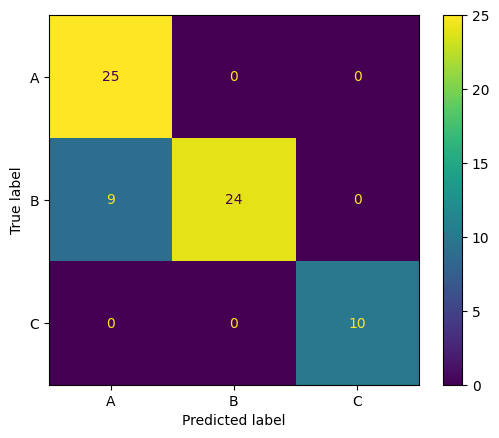

In [25]:
print("Accuracy on training set: {:.3f}".format(tree_reg.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree_reg.score(X_test, y_test)))
y_pred = tree_reg.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print("f1 score on test set: {:.3f}".format(f1))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

In [26]:
#RF classifier
rfc = RandomForestClassifier(n_estimators=6, random_state = 42)
y_train_rf = np.array(y_train).ravel()
rfc.fit(X_train, y_train_rf)

RandomForestClassifier(n_estimators=6, random_state=42)

Accuracy on training set: 0.970
Accuracy on test set: 0.868
f1 score on test set: 0.868


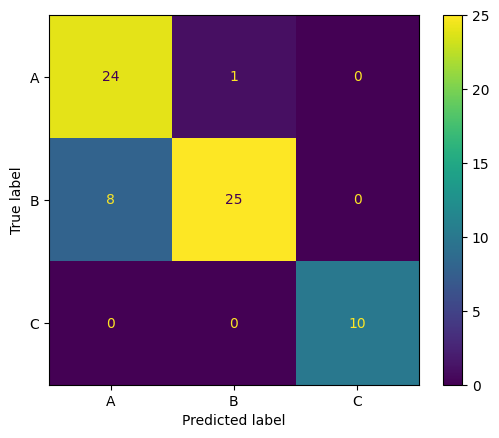

In [27]:
print("Accuracy on training set: {:.3f}".format(rfc.score(X_train, y_train_rf)))
print("Accuracy on test set: {:.3f}".format(rfc.score(X_test, y_test)))
y_pred = rfc.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print("f1 score on test set: {:.3f}".format(f1))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

In [28]:
#KNN
N_NEIGHBORS = 2 # KNN number of neighbors
y_train_knn = np.array(y_train).ravel()
knn_model = neighbors.KNeighborsClassifier(N_NEIGHBORS, weights='uniform')
knn_model.fit(X_train,y_train_knn)

KNeighborsClassifier(n_neighbors=2)

Accuracy on training set: 0.926
Accuracy on test set: 0.926
f1 score on test set: 0.927


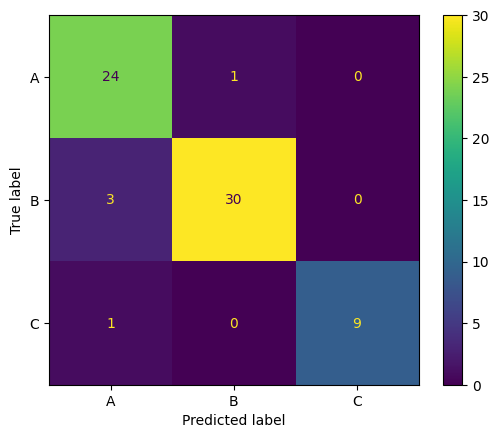

In [29]:
print("Accuracy on training set: {:.3f}".format(knn_model.score(X_train, y_train_knn)))
print("Accuracy on test set: {:.3f}".format(knn_model.score(X_test, y_test)))
y_pred = knn_model.predict(X_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print("f1 score on test set: {:.3f}".format(f1))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

## Using K-means result

In this section, the 12 K-means clusters (after attempts of 6-15 clusters, 12 produced the best accuracy in most models) were used as the input features to attempt to improve the accuracy of the model. In (1), only 3 clusters were used, because the goal was to see how well k-means separate the classes, which there were 3. Now since the k-means clusters are use for features, more clusters were made with a new k-means operation with 12 clusters and 20 initial cluster guesses.

Before:

Decision Tree: Accuracy on training set: 0.952 Accuracy on test set: 0.985 f1 score on test set: 0.985

Random Forest Classifier: Accuracy on training set: 0.982 Accuracy on test set: 0.926 f1 score on test set: 0.927

KNN: Accuracy on training set: 0.970 Accuracy on test set: 0.926 f1 score on test set: 0.927

After:

Decision Tree: Accuracy on training set: 0.852 Accuracy on test set: 0.779 f1 score on test set: 0.779

Random Forest Classifier: Accuracy on training set: 0.967 Accuracy on test set: 0.838 f1 score on test set: 0.839

KNN: Accuracy on training set: 0.871 Accuracy on test set: 0.853 f1 score on test set: 0.852

Overall, the accuracy of all models decreased, likely due to the k-means clusters not improving the features' ability to separate the material types. While the explained variance ratio is 0.998, it does not guarantee the improvement of classification outcome, which is unexpected.

Text(0, 0.5, 'feature2')

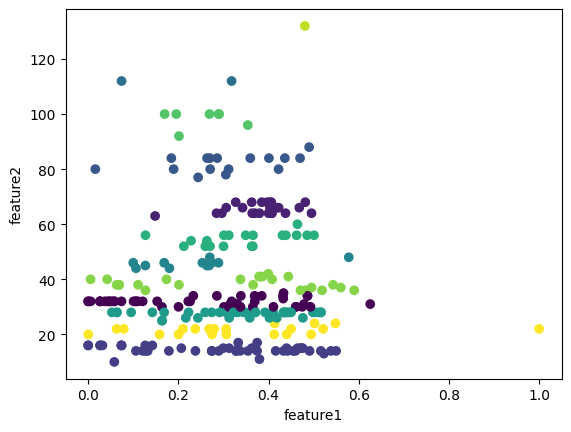

In [30]:
#K-means for feature engineering
X_train, X_test, y_train, y_test = train_test_split(features_scaled_encoded, target_raw, test_size=0.20,random_state=42)
kmeans = KMeans(n_clusters =12,n_init=20, random_state=42)
kmeans.fit(X_train)
y_pred = kmeans.predict(X_train)
plt.scatter(X_train.iloc[:,0], X_train.iloc[:,1], c=y_pred)
plt.xlabel('feature1')
plt.ylabel('feature2')

In [31]:
sum(pca.explained_variance_ratio_)

0.9983404678271182

In [32]:
#extracting distance features
dist_features_train = kmeans.transform(X_train)
dist_features_test = kmeans.transform(X_test)

In [33]:
#decision tree classifier
tree_reg = DecisionTreeClassifier(max_depth = 7, random_state = 42)
tree_reg.fit(dist_features_train, y_train)

DecisionTreeClassifier(max_depth=7, random_state=42)

Accuracy on training set: 0.852
Accuracy on test set: 0.779
f1 score on test set: 0.779


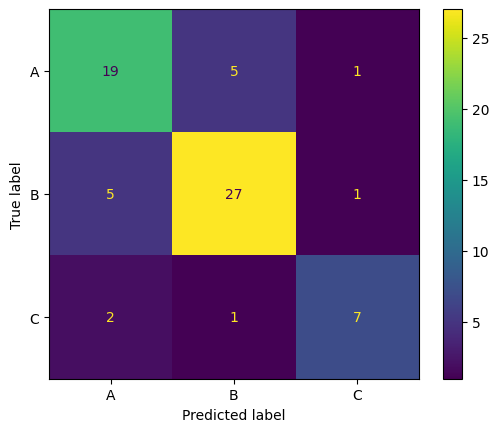

In [34]:
print("Accuracy on training set: {:.3f}".format(tree_reg.score(dist_features_train, y_train)))
print("Accuracy on test set: {:.3f}".format(tree_reg.score(dist_features_test, y_test)))
y_pred = tree_reg.predict(dist_features_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print("f1 score on test set: {:.3f}".format(f1))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

In [35]:
#RF classifier
rfc = RandomForestClassifier(n_estimators=6, random_state = 42)
y_train_rf = np.array(y_train).ravel()
rfc.fit(dist_features_train, y_train_rf)

RandomForestClassifier(n_estimators=6, random_state=42)

Accuracy on training set: 0.967
Accuracy on test set: 0.838
f1 score on test set: 0.839


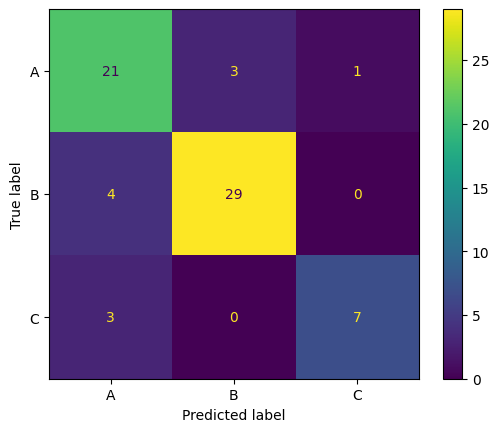

In [36]:
print("Accuracy on training set: {:.3f}".format(rfc.score(dist_features_train, y_train_rf)))
print("Accuracy on test set: {:.3f}".format(rfc.score(dist_features_test, y_test)))
y_pred = rfc.predict(dist_features_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print("f1 score on test set: {:.3f}".format(f1))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

In [37]:
#KNN
N_NEIGHBORS = 2 # KNN number of neighbors
y_train_knn = np.array(y_train).ravel()
knn_model = neighbors.KNeighborsClassifier(N_NEIGHBORS, weights='uniform')
knn_model.fit(dist_features_train,y_train_knn)

KNeighborsClassifier(n_neighbors=2)

Accuracy on training set: 0.871
Accuracy on test set: 0.853
f1 score on test set: 0.852


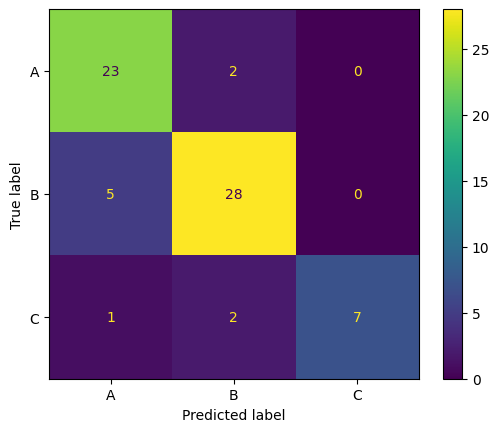

In [38]:
print("Accuracy on training set: {:.3f}".format(knn_model.score(dist_features_train, y_train_knn)))
print("Accuracy on test set: {:.3f}".format(knn_model.score(dist_features_test, y_test)))
y_pred = knn_model.predict(dist_features_test)
f1 = f1_score(y_test, y_pred, average='weighted')
print("f1 score on test set: {:.3f}".format(f1))
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

# 3. Hyper-parameter tuning

For the hyper-parameter tuning section, we first split the data with 0.2 test size, which was used for all models within this section.

In [39]:
# Assign X and y data
X = features_scaled_encoded

# Transform y data into numbers
encoder = LabelEncoder()
y = encoder.fit_transform(target_raw.values.ravel())

# Split the data into test and train
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

## Random Forest Classifier

In [40]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state = 42)
rf_clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [41]:
print("Accuracy on training set: {:.3f}".format(rf_clf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(rf_clf.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.985


First, we implemented Random Forest with default settings (100 trees with no max depth restriction). Then, we got the training and test accuracy are 1 and 0.985. This indicates that the model might be overfitting since it has the perfect training accuracy. This also might come from the small dataset that we were working on.  
To address this, we performed hyperparameter tuning for the model with number of estimators, maximum depth, minimum sample split, and minimum samples leaf.

For the hyper-parameter tuning, we are using gridsearch, and we chose to optimize the number of trees in the random forest, the max depth, the min sample split, and min sample leaf parameters. For the grid search scoring criteria we chose accuracy to look for the random forest model that could classify the best.

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

rf_classifier = RandomForestClassifier(random_state = 42)

# Define the hyperparameter grid to search
param_grid = {
    'n_estimators': [1, 3, 5],
    'max_depth': [10, 20],
    'min_samples_split': [2, 4],
    'min_samples_leaf': [1,3,5]
}

# Create GridSearchCV object
grid_search = GridSearchCV(rf_classifier, param_grid, cv=5, scoring='accuracy')

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
rf_best_params = grid_search.best_params_
best_classifier = grid_search.best_estimator_

# Evaluate the best classifier on the test set
best_predictions = best_classifier.predict(X_test)
best_accuracy = accuracy_score(y_test, best_predictions)

print("Best Hyperparameters:", rf_best_params)

print("Accuracy on training set: {:.3f}".format(best_classifier.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(best_classifier.score(X_test, y_test)))

Best Hyperparameters: {'max_depth': 20, 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 5}
Accuracy on training set: 0.982
Accuracy on test set: 0.941


After doing hyperparameter tuning and adjusting the ranges of the search grids several times, we have found the best model with high accuracy in training and testing, smaller gap between them, and without the sign of overfitting.  
The hyperparameters for Random Forest include maximum depth of 20, minimum leaf samples of 1, minimum samples split of 4, and number of estimators of 5.  
With these hyperparameters, the training and testing accuracy that we got were 0.982 and 0.941 respectively. This indicates that the model fits the training data and predicts the new data pretty well, and of similar accuracies as the previous models included in section (2) and (3).

## K Neighbors Classifier

For the KNN classifier, the default setting is used: 5 neighbors, uniform weights.

In [43]:
from sklearn.neighbors import KNeighborsClassifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train, y_train)

KNeighborsClassifier()

In [44]:
print("Accuracy on training set: {:.3f}".format(knn_clf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(knn_clf.score(X_test, y_test)))

Accuracy on training set: 0.867
Accuracy on test set: 0.853


The accuracy of default KNN Classifier suggests that the model does not fit a lot of the training data. The accuracy on the test set is slightly lower than the training set, which indicates that the model had some difficulties predicting new data. In general, this model does not seem to be overfitting, and the model needs more tuning.
Comparing to the previous random forest operation, the accuracies are lower which means that the data points are not distributed predictably in the feature space, which agrees with the previous conclusion from pca and K-means analysis in part (1).

In [45]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

knn_classifier = KNeighborsClassifier()

#Define the hyperparameter grid to search
#Round 1
param_grid = {
    'n_neighbors': [2,3,4],
    'weights': ['uniform','distance'],
    'metric': ['minkowski','euclidean','manhattan']
}

# Create GridSearchCV object
grid_search = GridSearchCV(knn_classifier, param_grid, cv=5, scoring='accuracy')

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
kn_best_params = grid_search.best_params_
best_classifier = grid_search.best_estimator_

# Evaluate the best classifier on the test set
best_predictions = best_classifier.predict(X_test)
best_accuracy = accuracy_score(y_test, best_predictions)

print("Best Hyperparameters:", kn_best_params)

print("Accuracy on training set: {:.3f}".format(best_classifier.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(best_classifier.score(X_test, y_test)))

Best Hyperparameters: {'metric': 'minkowski', 'n_neighbors': 2, 'weights': 'distance'}
Accuracy on training set: 1.000
Accuracy on test set: 0.971


However, when tuning the hyperparameters for KNN model, the training accuracy increased to 1. Although the test accuracy is improved to 0.971, this might be overfitting the data. Since this is a small dataset, KNN model seems to be pretty sensitive. When slightly adjusting the hyperparameters, the model became overfitting quickly.

To conclude, the Random Forest with proper tuning has helped increase the accuracy of predicting without overfitting.

# 4. Most Important Features on Random Forest

## Random Forest with best hyperparameters

In this section, we have collected the best hyperparameters from the tuning above to implement a new Random Forest model to calculate the importance scores on the features of our data.

In [46]:
# Extracting the best parameters for Random Forest model
best_n_estimators = rf_best_params['n_estimators']
best_max_depth = rf_best_params['max_depth']
best_min_samples_split = rf_best_params['min_samples_split']
best_min_samples_leaf = rf_best_params['min_samples_leaf']

# Create the classifier with the best hyperparameters
RF_clf2 = RandomForestClassifier(
    n_estimators=best_n_estimators,
    max_depth=best_max_depth,
    min_samples_split=best_min_samples_split,
    min_samples_leaf=best_min_samples_leaf,
    random_state=42
)
RF_clf2.fit(X_train, y_train)


RandomForestClassifier(max_depth=20, min_samples_split=4, n_estimators=5,
                       random_state=42)

## Importance Score

We used the for loop to collect the importance score of each feature and assign it with the right feature.

In [47]:
# List of the importance score of each factor
imp_score = {}
for score, name in zip(RF_clf2.feature_importances_, X.keys()):
    imp_score[name] = score

Then, we sorted it from highest score to the lowest.

In [48]:
# Sort from the most important feature
sorted_score = sorted(imp_score.items(), key=lambda x:x[1], reverse=True)

In [49]:
sorted_score

[('symmetry group_16', 0.2870516532627393),
 ('Unit Volume ', 0.0951515648888501),
 ('Formation Energy (eV)', 0.08135440581140817),
 ('symmetry group_21', 0.059896117606017374),
 ('symmetry group_31', 0.05687317718446311),
 ('DeltaE(eV)', 0.05508367809501082),
 ('Num_atoms', 0.05369231746102374),
 ('deltaE_Hull(eV)', 0.042525642969941733),
 ('symmetry group_40', 0.02795674050002796),
 ('symmetry group_20', 0.024831790210727015),
 ('Material Density(gm/cc)', 0.02378822479198933),
 ('symmetry group_25', 0.02066432331754464),
 ('symmetry group_32', 0.018970170922935962),
 ('symmetry group_2', 0.014886901788929124),
 ('symmetry group_29', 0.01328189344528603),
 ('symmetry group_4', 0.013208197808589395),
 ('symmetry group_6', 0.01301741221313143),
 ('symmetry group_1', 0.010093276902708313),
 ('symmetry group_5', 0.009075318913305496),
 ('symmetry group_43', 0.008835858097279426),
 ('symmetry group_11', 0.008056288093423732),
 ('Band Presence ', 0.007947017721746238),
 ('symmetry group_3',

Then, we implemented the model to look at how the accuracy changes with increasing number of features, from the most important features to the least. This done by using a for loop that loops through all the possible number of features in the sorted score list, and implementing them in the random forest models.

In [50]:
train_accuracy =[]
test_accuracy = []
num_fts = []

for i in range(len(sorted_score)):
    top_features = sorted_score[:i+1]

    # Testing Final Model

    # Implement train and test data from most important features
    features = list(X.keys())

    fts = [x[0] for x in top_features]

    X_train_f = X_train.loc[:, fts]
    X_test_f = X_test.loc[:, fts]

    RF_clf2.fit(X_train_f, y_train)

    train_accuracy.append(RF_clf2.score(X_train_f, y_train))
    test_accuracy.append(RF_clf2.score(X_test_f, y_test))
    num_fts.append(i+1)

    # print("With", i+1,"important features,")
    # print("Accuracy on training set: {:.3f}".format(RF_clf2.score(X_train_f, y_train)))
    # print("Accuracy on test set: {:.3f}".format(RF_clf2.score(X_test_f, y_test)))


Text(0.5, 1.0, 'Train & Test Accuracy of RF model with the Increase in Number of Features')

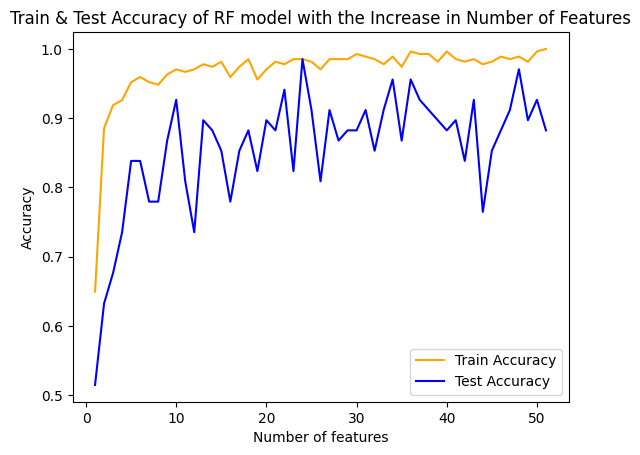

In [51]:
plt.figure()
plt.plot(num_fts, train_accuracy, label='Train Accuracy', color='orange')
plt.plot(num_fts, test_accuracy, label='Test Accuracy', color='blue')
plt.legend()
plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.title('Train & Test Accuracy of RF model with the Increase in Number of Features')

We plotted out the accuracy changes with the increase of number of features used in training. Unexpectedly, a few first most important features have a large impact on how the model behaves. In general, more important features were added, the higher accuracy in training and testing the model gets. Although there is an increasing trend, adding more features also create some fluctuations. Some features when added make the model less accurate, and vice versa, some make it better.
Better model would be the one that produces the least gap between the training and testing accuracy. Higher training accuracy with larger gap might experience overfitting.

In [52]:
gap = []
for i in range(len(train_accuracy)):
    gap.append( train_accuracy[i] - test_accuracy[i])
best_num_fts = gap.index(min(gap)) + 1
# print(gap.index(min(gap)))
print('The best number of features used in training the model is', best_num_fts)

The best number of features used in training the model is 24


Therefore, to avoid overfitting, the best number of features to use is 24.  
Below is the final model with Random Forest with max depth of 20, min samples leaf of 1, min samples split of 4, and number of estimators of 5, using top 24 most important features.

In [53]:
# Final Model

# X_train with top 24 features:
# Implement train and test data from most important features
top_features_final = sorted_score[:24]

fts_final = [x[0] for x in top_features_final]

X_train_final = X_train.loc[:, fts_final]
X_test_final = X_test.loc[:, fts_final]

RF_clf2.fit(X_train_final, y_train)

print("Accuracy on training set: {:.3f}".format(RF_clf2.score(X_train_final, y_train)))
print("Accuracy on test set: {:.3f}".format(RF_clf2.score(X_test_final, y_test)))

Accuracy on training set: 0.985
Accuracy on test set: 0.985


# 5. XGBoost

In [54]:
!pip install xgboost
import xgboost as xgb

In [55]:
# Create XGBoost Model
xgb_clf = xgb.XGBClassifier()

For the XGBoost implementation, the default values are used: 0.3 leanring rate, 0 min split loss, 6 max depth, 0 max delta steps, uniform sample method, and so on.

In [56]:
# Fit the data
xgb_clf.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, objective='multi:softprob', ...)

In [57]:
# Accuracy of XGBoost
print("Accuracy on training set: {:.3f}".format(xgb_clf.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(xgb_clf.score(X_test, y_test)))

Accuracy on training set: 1.000
Accuracy on test set: 0.971


A grid search was done to tune the hyper parameters, which include number of trees, max depth for each tree, learning rate, min split size for each nodes, subsample, and the subsample ratio of columns when constructing each tree. The scoring criteria remained accuracy, which helps us to find the best classifier hyperparameters.

In [58]:
# Hyperparameter tuning

xgb_clf1 = xgb.XGBClassifier()

# Define the hyperparameter grid to search

param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [None,1,3],
    'learning_rate': [None, 0.01,0.05],
    'min_child_weight': [0, 1],
    'subsample': [None, 0.5, 1.0],
    'colsample_bytree': [None, 0.5, 1.0],
}

# Create GridSearchCV object
grid_search = GridSearchCV(xgb_clf1, param_grid, cv=5, scoring='accuracy')

# Fit the model with the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and the best estimator
xgb_best_params = grid_search.best_params_
best_classifier = grid_search.best_estimator_

# Evaluate the best classifier on the test set
best_predictions = best_classifier.predict(X_test)
best_accuracy = accuracy_score(y_test, best_predictions)

print("Best Hyperparameters:", xgb_best_params)

print("Accuracy on training set: {:.3f}".format(best_classifier.score(X_train, y_train)))
print("Accuracy on test set: {:.3f}".format(best_classifier.score(X_test, y_test)))

Best Hyperparameters: {'colsample_bytree': None, 'learning_rate': None, 'max_depth': 1, 'min_child_weight': 0, 'n_estimators': 100, 'subsample': None}
Accuracy on training set: 0.993
Accuracy on test set: 0.985


Implementing XGBoost to the dataset after hyperparameter tuning, the best accuracy we got is 0.993 on the training and 0.985 on the test data. The XGBoost accuracy is consistent with other machine-learning and Neural network accuraies which suggests that the XGBoost results were properly optimized.

# 6. Neural Network

In [59]:
#keras NN
import tensorflow as tf
from sklearn.metrics import accuracy_score

For the neural network, the test size is set to 0.2, with label encoded target values. The base NN model consisted of 1 input layer, 3 dense layers with 300 nodes, relu activation function, and he_normal kernal initializer as used in class. 3 nodes were used for output, because the target values are 3 classes of materials. A dropout rate of 0.5 is used to enhance individual neuron performance, and batch noramlization was used to normalize each activation layer's outputs. When compiling the model, loss function of sparse categorical crossentropy was used since this is a multi class classification task. The optimizer used is Adam with learning_rate=0.01, and decay parameters beta_2=0.999, epsilon=1e-7, so that the learning rate slows down as we approach convergence.

In [60]:
X_train, X_test , y_train, y_test = train_test_split(features_scaled_encoded, target_pca, test_size=0.20,random_state=42)
X_train.shape

(271, 51)

In [61]:
#model building with drop out
nn_model = tf.keras.Sequential([
    #input layer
    tf.keras.layers.Flatten(input_shape= [51]),
    #dense layer 0
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    #dense layer 1
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    #dense layer 2
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    #output layer
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(3, activation="softmax") #3 output material types
])

In [62]:
nn_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 51)                0         
                                                                 
 dropout (Dropout)           (None, 51)                0         
                                                                 
 dense (Dense)               (None, 300)               15600     
                                                                 
 batch_normalization (Batch  (None, 300)               1200      
 Normalization)                                                  
                                                                 
 dropout_1 (Dropout)         (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 300)               90300     
                                                        

In [63]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_2=0.999, epsilon=1e-7)

The model was trained with the validation_split of 0.33 referenced from lecture, 300 epoches (where accuracy reaches close to 0.9), and batch size of 10000 (better than 100, 1000 batch size settings), verbose is set to 0 so that we can see the accuracy results in the same window.

The training accuracy and testing accuracy were comparable to the best machine learning methods before, with 0.9926 training accuracy and 0.9412 testing accuracy, with highier testing accuracy than random forest and KNN. From the model loss graph we can see that the loss function were minimized the most from first to around 75th epoch, we chose to run more epochs because wehn the epoches were reduced to 150 the accuacy dropped significantly to around 0.47.

In [64]:
#compile the model
nn_model.compile(loss="sparse_categorical_crossentropy", # sparse label bec mutually exclusive outcome of the model output (the actual label)
              optimizer=optimizer,
              metrics=["accuracy"])

In [65]:
history = nn_model.fit(X_train, y_train, validation_split=0.33, epochs=300,
        batch_size=10000, verbose=0)

In [66]:
nn_model.evaluate(X_train, y_train)

9/9 [==============================] - 0s 4ms/step - loss: 0.3060 - accuracy: 0.9077


[0.30602383613586426, 0.9077490568161011]

In [67]:
nn_model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 5ms/step - loss: 0.4313 - accuracy: 0.8529


[0.43128398060798645, 0.8529411554336548]

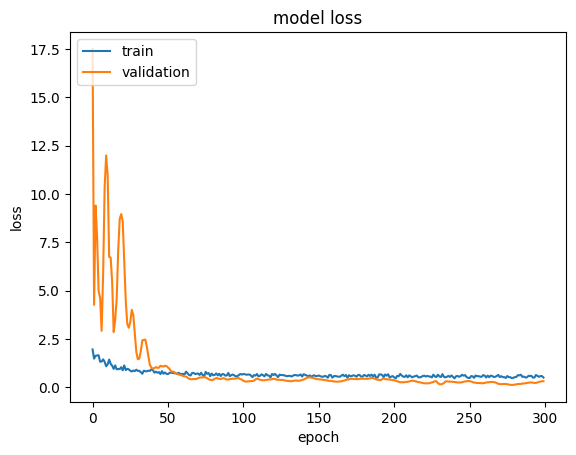

In [68]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

Alternative Neural Network node number

In this section the base neural network was copied, and only the number of nodes in the dense layers were changed, other parameters were kept the same as controls. For the first NN in this section, each layer increased their nodes from 300 to 500. For the second NN, each layer decreased their nodes from 300 to 100.

Base:

Training accuracy:0.9926 Testing accuracy:0.9412

500 nodes:

Training accuracy:0.9852 Testing accuracy:0.9265

100 nodes:

Training accuracy:0.9963 Testing accuracy:0.9412

The increase of nodes per layer lowered the accuraies of training and testing, and reducing the nodes did not improve the accuracies noticeably. This is likely due to overfitting from too many nodes per layer.

In [69]:
#model building with drop out
nn_model = tf.keras.Sequential([
    #input layer
    tf.keras.layers.Flatten(input_shape= [51]),
    #dense layer 0
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(500, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    #dense layer 1
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(500, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    #dense layer 2
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(500, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    #output layer
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(3, activation="softmax") #3 output material types
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_2=0.999, epsilon=1e-7)
#compile the model
nn_model.compile(loss="sparse_categorical_crossentropy", # sparse label bec mutually exclusive outcome of the model output (the actual label)
              optimizer=optimizer,
              metrics=["accuracy"])
nn_model.fit(X_train, y_train, validation_split=0.33, epochs=300,
        batch_size=10000, verbose=0)

In [70]:
nn_model.evaluate(X_train, y_train)

9/9 [==============================] - 0s 6ms/step - loss: 0.1698 - accuracy: 0.9889


[0.16983039677143097, 0.9889298677444458]

In [71]:
nn_model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 10ms/step - loss: 0.2383 - accuracy: 0.9412


[0.238314688205719, 0.9411764740943909]

In [72]:
#model building with drop out
nn_model = tf.keras.Sequential([
    #input layer
    tf.keras.layers.Flatten(input_shape= [51]),
    #dense layer 0
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    #dense layer 1
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    #dense layer 2
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(100, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    #output layer
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(3, activation="softmax") #3 output material types
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_2=0.999, epsilon=1e-7)
#compile the model
nn_model.compile(loss="sparse_categorical_crossentropy", # sparse label bec mutually exclusive outcome of the model output (the actual label)
              optimizer=optimizer,
              metrics=["accuracy"])
nn_model.fit(X_train, y_train, validation_split=0.33, epochs=300,
        batch_size=10000, verbose=0)

In [73]:
nn_model.evaluate(X_train, y_train)

9/9 [==============================] - 0s 4ms/step - loss: 0.2856 - accuracy: 0.9779


[0.2856258451938629, 0.9778597950935364]

In [74]:
nn_model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 6ms/step - loss: 0.3510 - accuracy: 0.9412


[0.351018488407135, 0.9411764740943909]

Alternative Neural Network layers

In this section the base neural network was copied, and only the number of dense layers were changed, other parameters were kept the same as controls. For the first NN in this section, 3 dense layers were increased to 4 layers. For the second NN, number of dense layers decreased from 3 to 2.

Base:

Training accuracy:0.9926 Testing accuracy:0.9412

4 dense layers:

Training accuracy: 0.7306 Testing accuracy:0.6471

2 dense layers:

Training accuracy:0.9779 Testing accuracy:0.9265

The increase of dense layers lowered the accuraies of training and testing, and reducing the layers also lowered the accuracies. This is likely due to overfitting from too many layers, and decreasing layers has lead to slight underfitting.

In [75]:
#model building with drop out
nn_model = tf.keras.Sequential([
    #input layer
    tf.keras.layers.Flatten(input_shape= [51]),
    #dense layer 0
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    #dense layer 1
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    #dense layer 2
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
     #dense layer 3
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    #output layer
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(3, activation="softmax") #3 output material types
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_2=0.999, epsilon=1e-7)
#compile the model
nn_model.compile(loss="sparse_categorical_crossentropy", # sparse label bec mutually exclusive outcome of the model output (the actual label)
              optimizer=optimizer,
              metrics=["accuracy"])
nn_model.fit(X_train, y_train, validation_split=0.33, epochs=300,
        batch_size=10000, verbose=0)

In [76]:
nn_model.evaluate(X_train, y_train)

9/9 [==============================] - 0s 5ms/step - loss: 0.3727 - accuracy: 0.8635


[0.372651070356369, 0.8634686470031738]

In [77]:
nn_model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 8ms/step - loss: 0.5059 - accuracy: 0.7500


[0.5058730244636536, 0.75]

In [78]:
#model building with drop out
nn_model = tf.keras.Sequential([
    #input layer
    tf.keras.layers.Flatten(input_shape= [51]),
    #dense layer 0
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    #dense layer 1
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(300, activation="relu",
                          kernel_initializer="he_normal"),
    tf.keras.layers.BatchNormalization(),
    #output layer
    tf.keras.layers.Dropout(rate=0.5),
    tf.keras.layers.Dense(3, activation="softmax") #3 output material types
])
optimizer = tf.keras.optimizers.Adam(learning_rate=0.01, beta_2=0.999, epsilon=1e-7)
#compile the model
nn_model.compile(loss="sparse_categorical_crossentropy", # sparse label bec mutually exclusive outcome of the model output (the actual label)
              optimizer=optimizer,
              metrics=["accuracy"])
nn_model.fit(X_train, y_train, validation_split=0.33, epochs=300,
        batch_size=10000, verbose=0)

In [79]:
nn_model.evaluate(X_train, y_train)

9/9 [==============================] - 0s 3ms/step - loss: 0.1693 - accuracy: 0.9926


[0.16932010650634766, 0.9926199316978455]

In [80]:
nn_model.evaluate(X_test, y_test)

3/3 [==============================] - 0s 9ms/step - loss: 0.2332 - accuracy: 0.9265


[0.23316724598407745, 0.9264705777168274]